<a href="https://colab.research.google.com/github/ap12798/Applied_Deep_Learning/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This Applied Deep Learning Project will be to determine the stock trend of Deere (stock abrev DE) for the beginning of 2021. The notebook will make use of the library yfinance to access Deere's beginning day stock price for the past 10 years. Stacked LSTM, dropout, adam optimizer



1.   Best Model Stacked LSTM with 60 days of reference prices
2.   Stacked LSTM with 30 and 90 days of reference prices
3.   Alternate RNN models (Simple RNN, Layered RNN, Bidrectional RNN)



In [286]:
!pip install yfinance

In [287]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import statistics as stat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import Dropout

Training Set and Test set. Test set isn't used until later.

In [288]:
data_train = yf.download("DE", start="2010-01-01", end="2020-12-31") # defaults to one price per day
data_test = yf.download("DE", start="2021-01-01", end="2021-05-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Looking at the pandas output complete from yahoo, will trim down to just open price**

In [290]:
data_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,54.740002,56.200001,54.340000,56.060001,43.838268,3974600
2010-01-05,56.189999,56.560001,55.599998,55.849998,43.674049,3007400
2010-01-06,55.570000,56.040001,55.220001,55.700001,43.556759,2854500
2010-01-07,55.380001,56.130001,55.169998,56.099998,43.869537,2694000
2010-01-08,55.779999,57.750000,55.299999,57.630001,45.065994,4165500


In [149]:
data_train.shape, data_test.shape 

((2768, 6), (102, 6))

In [291]:
train_set = data_train.iloc[:, 1:2].values # grabbing just the stock open price, iloc used to get right index for opening (creating a numpy array)
test_set = data_test.iloc[:, 1:2].values

In [152]:
train_set.shape, test_set.shape

((2768, 1), (102, 1))

No handles with labels found to put in legend.


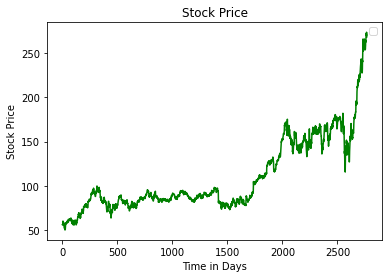

In [279]:
plt.plot(train_set, color = 'green')
plt.title('Stock Price')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [292]:
# normalizing the test data
sc = MinMaxScaler() # defaults to zero and one
train_set_scaled = sc.fit_transform(train_set) # applying fit transform method to sc

X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(60, 2768): #l en(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-60:i, 0]) # adding data to X_train (60 previous stock price before i'th day)
  y_train.append(train_set_scaled[i,0]) # adding data to y_train (time at t+1) - i because indexes start at zero
X_train = np.array(X_train) # convert list to numpy array
y_train = np.array(y_train) # convert list to numpy array

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data and adding a dimension for the single indicator we are trying to predict


# need to get roughly 3 months (20 per month) 60 previous stock prices from the original data
# data_set_total = yf.download("DE", start = "2010-01-01", end = "2021-05-31")
# data_set_total = data_set_total['Open']

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

inputs = data_set_total[len(data_set_total) - len(data_test) - 60:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(60, 162): # 60 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

**Taking a look at our new training set that is normalized from zero to one. Makes sense that the later values are closer to one after looking at the upward trend from above graph.**

**At each time 't' the RNN will look at the 60 previous stock prices before time 't' and time 't' and based on the trend, try to predict the best output at t+1**

*Tried 30 timesteps and 90 timesteps and landed on 60 (3 months)being the best based on output**


In [156]:
len(train_set)

2768

In [158]:
X_train.shape

(2708, 60)

In [160]:
X_train.shape # new 3-d array

(2708, 60, 1)

In [295]:
# hyperparameters
dropout = 0.2
neurons = 128 # tried 64
epochs = 16 # tried 50 and mean square error didn't do much after 16
batch_size = 32
optimizer = 'adam'
loss = 'mean_squared_error'

### **1. Stacked LSTM**

 

*   #### Model seems to perform well and catches most of the stock price changes.
*   #### Also the average % error is low


In [296]:
model_stacked_LSTM = Sequential()
model_stacked_LSTM.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1))) # first layer
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(LSTM(units = neurons))
model_stacked_LSTM.add(Dropout(dropout))
model_stacked_LSTM.add(Dense(1))

In [297]:
model_stacked_LSTM.compile(optimizer = optimizer, loss = loss)

In [298]:
model_stacked_LSTM.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
85/85 [==============================] - 29s 255ms/step - loss: 0.0105
Epoch 2/16
85/85 [==============================] - 22s 255ms/step - loss: 0.0018
Epoch 3/16
85/85 [==============================] - 22s 255ms/step - loss: 0.0017
Epoch 4/16
85/85 [==============================] - 22s 255ms/step - loss: 0.0013
Epoch 5/16
85/85 [==============================] - 22s 256ms/step - loss: 0.0011
Epoch 6/16
85/85 [==============================] - 22s 257ms/step - loss: 0.0010
Epoch 7/16
85/85 [==============================] - 22s 258ms/step - loss: 0.0011
Epoch 8/16
85/85 [==============================] - 22s 258ms/step - loss: 0.0011
Epoch 9/16
85/85 [==============================] - 22s 259ms/step - loss: 7.6658e-04
Epoch 10/16
85/85 [==============================] - 22s 260ms/step - loss: 8.9471e-04
Epoch 11/16
85/85 [==============================] - 22s 265ms/step - loss: 6.5101e-04
Epoch 12/16
85/85 [==============================] - 22s 259ms/step - loss: 7.4383e-

In [300]:
predicted_stock_price_stacked_LSTM = model_stacked_LSTM.predict(X_test)
predicted_stock_price_stacked_LSTM = sc.inverse_transform(predicted_stock_price_stacked_LSTM) # going back from normalizing

Chart below shows the actual stock price in green and predicted stock price in blue. No training data is displayed here.

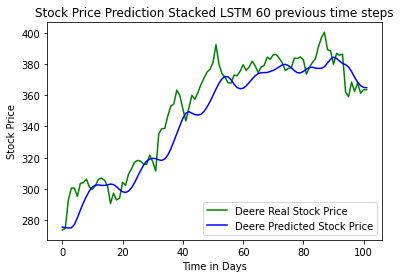

In [301]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction Stacked LSTM 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model tracks well over time but doesn't do a great job of finding all peaks. Accuracy is the best compared to the 30 and 90 day trials

In [302]:
# Function to calculate the percentage
def percent_error(a, b) :
    result = int(((b - a) * 100) / a)
    return result

In [303]:
print(percent_error(predicted_stock_price_stacked_LSTM[20],test_set[20]), "%")

2 %


In [304]:
print(percent_error(predicted_stock_price_stacked_LSTM[50],test_set[50]), "%")

5 %


In [305]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM, test_set)]
(sum(c)/len(c))[0]

2.8087891753126804

### **2.Below are simulations with different time steps, all stacked LSTMs**


* 30 time steps loss: .00056840
* 30 time steps accuracy: 2.9%
* 60 time steps loss: .00063653
* 60 time steps accuracy: 2.8%
* 90 time steps loss: .00069412
* 90 time steps accuracy: 6.6%

In [306]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(30, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-30:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

inputs = data_set_total[len(data_set_total) - len(data_test) - 30:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(30, 132): # 30 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [307]:
model_stacked_LSTM_30 = Sequential()
model_stacked_LSTM_30.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(LSTM(units = neurons))
model_stacked_LSTM_30.add(Dropout(dropout))
model_stacked_LSTM_30.add(Dense(1))

In [308]:
model_stacked_LSTM_30.compile(optimizer = optimizer, loss = loss)

In [309]:
model_stacked_LSTM_30.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
86/86 [==============================] - 18s 135ms/step - loss: 0.0157
Epoch 2/16
86/86 [==============================] - 12s 134ms/step - loss: 0.0017
Epoch 3/16
86/86 [==============================] - 11s 132ms/step - loss: 0.0017
Epoch 4/16
86/86 [==============================] - 11s 133ms/step - loss: 0.0014
Epoch 5/16
86/86 [==============================] - 12s 134ms/step - loss: 0.0012
Epoch 6/16
86/86 [==============================] - 12s 134ms/step - loss: 0.0011
Epoch 7/16
86/86 [==============================] - 11s 133ms/step - loss: 8.8782e-04
Epoch 8/16
86/86 [==============================] - 11s 133ms/step - loss: 8.1120e-04
Epoch 9/16
86/86 [==============================] - 11s 133ms/step - loss: 8.4385e-04
Epoch 10/16
86/86 [==============================] - 11s 132ms/step - loss: 9.2445e-04
Epoch 11/16
86/86 [==============================] - 12s 136ms/step - loss: 7.5619e-04
Epoch 12/16
86/86 [==============================] - 12s 136ms/step - loss: 

In [310]:
predicted_stock_price_stacked_LSTM_30 = model_stacked_LSTM_30.predict(X_test)
predicted_stock_price_stacked_LSTM_30 = sc.inverse_transform(predicted_stock_price_stacked_LSTM_30) # going back from normalizing

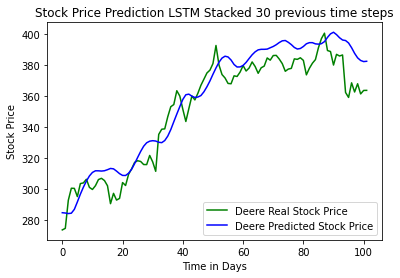

In [322]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM_30, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction LSTM Stacked 30 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## It seems like this model is slightly slower to respond to changes in stock price, still good accuracy but doesn't track as well as the 60 day model

In [315]:
print(abs(percent_error(predicted_stock_price_stacked_LSTM_30[20],test_set[20])), "%")

1 %


In [320]:
print(abs(percent_error(predicted_stock_price_stacked_LSTM_30[50],test_set[50])), "%")

4 %


In [321]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM_30,test_set)]
(sum(c)/len(c))[0]

2.9222895548364223

### 90 day window

In [323]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(90, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-90:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)


inputs = data_set_total[len(data_set_total) - len(data_test) - 90:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(90, 192): # 90 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-90:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [324]:
model_stacked_LSTM_90 = Sequential()
model_stacked_LSTM_90.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(units = neurons, return_sequences = True))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(LSTM(units = neurons))
model_stacked_LSTM_90.add(Dropout(dropout))
model_stacked_LSTM_90.add(Dense(1))

In [325]:
model_stacked_LSTM_90.compile(optimizer = optimizer, loss = loss)

In [326]:
model_stacked_LSTM_90.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
84/84 [==============================] - 38s 368ms/step - loss: 0.0167
Epoch 2/16
84/84 [==============================] - 31s 369ms/step - loss: 0.0014
Epoch 3/16
84/84 [==============================] - 31s 371ms/step - loss: 0.0014
Epoch 4/16
84/84 [==============================] - 31s 371ms/step - loss: 0.0014
Epoch 5/16
84/84 [==============================] - 31s 371ms/step - loss: 0.0024
Epoch 6/16
84/84 [==============================] - 31s 374ms/step - loss: 0.0012
Epoch 7/16
84/84 [==============================] - 31s 369ms/step - loss: 0.0010
Epoch 8/16
84/84 [==============================] - 31s 371ms/step - loss: 9.6028e-04
Epoch 9/16
84/84 [==============================] - 31s 369ms/step - loss: 9.7139e-04
Epoch 10/16
84/84 [==============================] - 31s 371ms/step - loss: 7.2449e-04
Epoch 11/16
84/84 [==============================] - 31s 369ms/step - loss: 7.6042e-04
Epoch 12/16
84/84 [==============================] - 31s 369ms/step - loss: 9.09

In [327]:
predicted_stock_price_stacked_LSTM_90 = model_stacked_LSTM_90.predict(X_test)
predicted_stock_price_stacked_LSTM_90 = sc.inverse_transform(predicted_stock_price_stacked_LSTM_90) # going back from normalizing

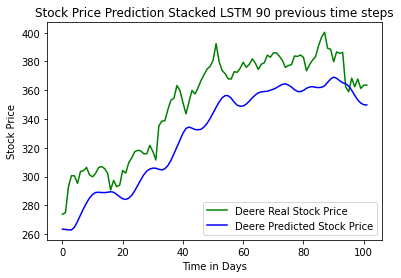

In [341]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_stacked_LSTM_90, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction Stacked LSTM 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [329]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_stacked_LSTM_90, test_set)]
(sum(c)/len(c))[0]

6.641087643476417

### Below is running a simple RNN for comparision to the stacked LSTM

In [366]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(32))
model_RNN.add(Dropout(dropout))
model_RNN.add(Dense(1))

In [367]:
model_RNN.compile(optimizer = optimizer, loss = loss)

In [368]:
model_RNN.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
84/84 [==============================] - 3s 12ms/step - loss: 0.0199
Epoch 2/16
84/84 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 3/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 4/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 5/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 6/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 7/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 8/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 9/16
84/84 [==============================] - 1s 12ms/step - loss: 0.0011
Epoch 10/16
84/84 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 11/16
84/84 [==============================] - 1s 11ms/step - loss: 9.7449e-04
Epoch 12/16
84/84 [==============================] - 1s 12ms/step - loss: 7.9777e-04
Epoch 13/16
84/84 [==========

In [369]:
predicted_stock_price_RNN = model_RNN.predict(X_test)
predicted_stock_price_RNN = sc.inverse_transform(predicted_stock_price_RNN) # going back from normalizing

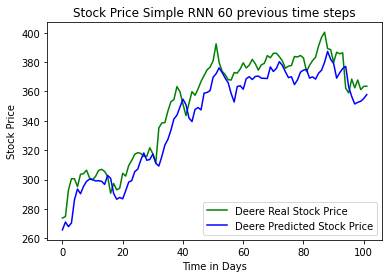

In [370]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_RNN, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Simple RNN 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Need Model Comment

In [349]:
print(percent_error(predicted_stock_price_RNN[20],test_set[20]), "%")

3 %


In [350]:
print(percent_error(predicted_stock_price_RNN[50],test_set[50]), "%")

4 %


In [351]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_RNN,test_set)]
(sum(c)/len(c))[0]

3.418013259439415

### Now shifting to a couple different RNN types to compare against the Stacked LSTM
Below is a simple RNN but with a couple layers


*   Simple RNN Loss: .000184148
*   Simple RNN Accuracy: 6 %




In [352]:
model_rnn_layer = Sequential()
model_rnn_layer.add(SimpleRNN(32, return_sequences=True))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(SimpleRNN(32, return_sequences=True))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(SimpleRNN(32, return_sequences=True))
model_rnn_layer.add(Dropout(dropout))
model_rnn_layer.add(SimpleRNN(32))
model_rnn_layer.add(Dense(1))

In [353]:
model_rnn_layer.compile(optimizer = optimizer, loss = loss)

In [354]:
model_rnn_layer.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
84/84 [==============================] - 11s 56ms/step - loss: 0.0666
Epoch 2/16
84/84 [==============================] - 5s 58ms/step - loss: 3.1468e-04
Epoch 3/16
84/84 [==============================] - 5s 57ms/step - loss: 2.5605e-04
Epoch 4/16
84/84 [==============================] - 5s 55ms/step - loss: 2.2623e-04
Epoch 5/16
84/84 [==============================] - 5s 56ms/step - loss: 2.2900e-04
Epoch 6/16
84/84 [==============================] - 5s 56ms/step - loss: 2.6351e-04
Epoch 7/16
84/84 [==============================] - 5s 56ms/step - loss: 2.1632e-04
Epoch 8/16
84/84 [==============================] - 5s 56ms/step - loss: 2.0696e-04
Epoch 9/16
84/84 [==============================] - 5s 55ms/step - loss: 2.3052e-04
Epoch 10/16
84/84 [==============================] - 5s 57ms/step - loss: 2.4608e-04
Epoch 11/16
84/84 [==============================] - 5s 57ms/step - loss: 1.9487e-04
Epoch 12/16
84/84 [==============================] - 5s 54ms/step - loss: 2.5

In [355]:
predicted_stock_price_rnn_layer = model_rnn_layer.predict(X_test)
predicted_stock_price_rnn_layer = sc.inverse_transform(predicted_stock_price_rnn_layer) # going back from normalizing

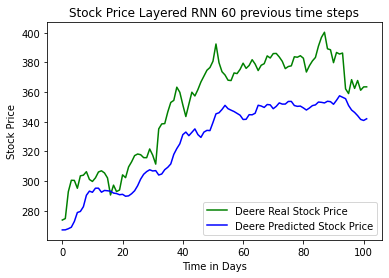

In [356]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_rnn_layer, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Layered RNN 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model is even worse than previous models, percent error is greater and you can tell by graph that predicted 'blue' is shifted down consistently

In [357]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price_rnn_layer,test_set)]
(sum(c)/len(c))[0]

7.508727516915047

In [358]:
model_bidirectional_LSTM = Sequential()
model_bidirectional_LSTM.add (Bidirectional(LSTM(32, input_shape = (X_train.shape[1], 1))))
model_bidirectional_LSTM.add(Dropout(dropout))
model_bidirectional_LSTM.add(Dense(1))
model_bidirectional_LSTM.compile(optimizer = optimizer, loss = loss)
model_bidirectional_LSTM.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
84/84 [==============================] - 8s 40ms/step - loss: 0.0423
Epoch 2/16
84/84 [==============================] - 4s 42ms/step - loss: 0.0011
Epoch 3/16
84/84 [==============================] - 3s 40ms/step - loss: 7.1041e-04
Epoch 4/16
84/84 [==============================] - 3s 41ms/step - loss: 5.8231e-04
Epoch 5/16
84/84 [==============================] - 3s 40ms/step - loss: 5.2561e-04
Epoch 6/16
84/84 [==============================] - 3s 40ms/step - loss: 4.6027e-04
Epoch 7/16
84/84 [==============================] - 3s 40ms/step - loss: 3.9292e-04
Epoch 8/16
84/84 [==============================] - 3s 41ms/step - loss: 3.7440e-04
Epoch 9/16
84/84 [==============================] - 3s 41ms/step - loss: 3.1536e-04
Epoch 10/16
84/84 [==============================] - 3s 41ms/step - loss: 3.2976e-04
Epoch 11/16
84/84 [==============================] - 3s 40ms/step - loss: 3.2871e-04
Epoch 12/16
84/84 [==============================] - 3s 39ms/step - loss: 3.0707e-

In [359]:
predicted_stock_price_birectional_LSTM = model_bidirectional_LSTM.predict(X_test)
predicted_stock_price_birectional_LSTM = sc.inverse_transform(predicted_stock_price_birectional_LSTM) # going back from normalizing

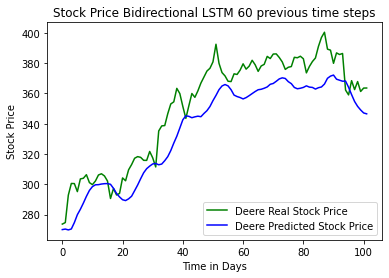

In [360]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price_birectional_LSTM, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Bidirectional LSTM 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()